<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning2020/blob/main/simple_classifier_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


# Classifier comparison


A comparison of a several classifiers in scikit-learn on synthetic datasets.
The point of this example is to illustrate the nature of decision boundaries
of different classifiers.
This should be taken with a grain of salt, as the intuition conveyed by
these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated
linearly and the simplicity of classifiers such as naive Bayes and linear SVMs
might lead to better generalization than is achieved by other classifiers.

The plots show training points in solid colors and testing points
semi-transparent. The lower right shows the classification accuracy on the test
set.


Automatically created module for IPython interactive environment


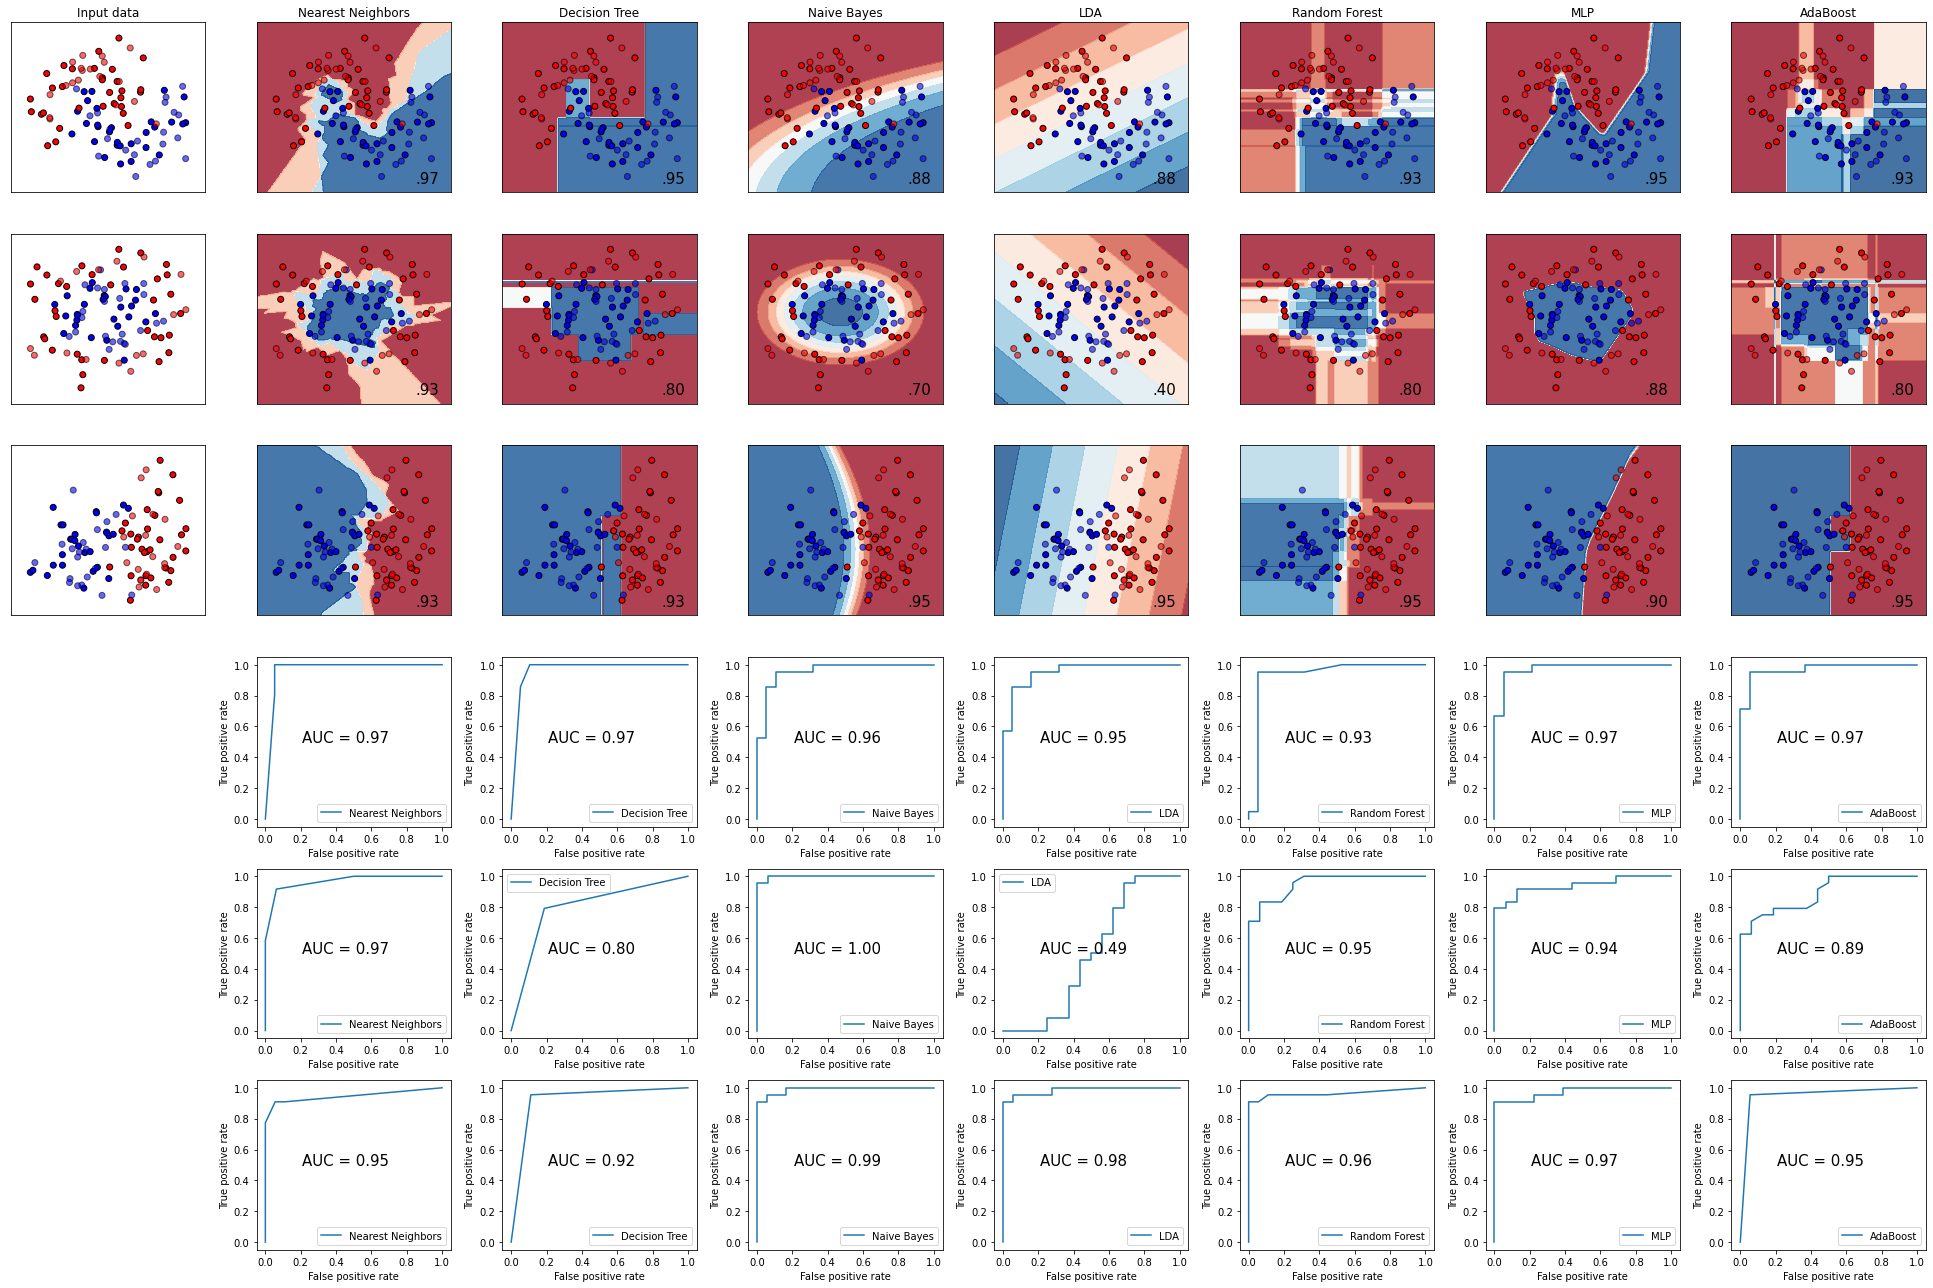

In [4]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause
# Modified by MW

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

h = .02  # step size in the mesh

names = ["Nearest Neighbors", 
         "Decision Tree", 
         "Naive Bayes","LDA", "Random Forest", "MLP", "AdaBoost"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=0.0001, max_iter=1000,solver='lbfgs', random_state=1,
                                     hidden_layer_sizes=[10, 10]),   # default alpha=0.0001
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=10,learning_rate=0.1)]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 18))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(2*len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(2*len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        
        # plot the roc curve
        ax = plt.subplot(2*len(datasets), len(classifiers) + 1, i+len(datasets)*(len(classifiers)+1))
        ZZ = clf.predict_proba(X_test)[:, 1]
        #print(y_test.shape,"   ",Z.shape)
        fpr, tpr, _ = roc_curve(y_test, ZZ)
        ax.plot(fpr, tpr, label=name)
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        #plt.title('ROC curve')
        plt.legend(loc='best')
        auc = roc_auc_score(y_test, ZZ)
        ax.text(0.7, 0.5, ('AUC = %.2f' % auc),
                size=15, horizontalalignment='right')


        i += 1

plt.tight_layout()
plt.show()